In [1]:
%matplotlib inline 

from __future__ import division

import sys
if '../' not in sys.path: sys.path.append("../")

import numpy as np
import amnet
import control 

import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

In [2]:
def make_vgc(alpha):
    # inputs
    e_var = amnet.Variable(1, name='e')
    edot_var = amnet.Variable(1, name='edot')
    x = amnet.stack(e_var, edot_var)

    # affine transformations
    zero1 = amnet.atoms.make_const(np.zeros(1), x)
    ae    = amnet.AffineTransformation(np.array([[alpha, 0]]), x, np.zeros(1))
    e     = amnet.AffineTransformation(np.array([[1, 0]]), x, np.zeros(1))
    neg_e = amnet.AffineTransformation(np.array([[-1, 0]]), x, np.zeros(1))
    edot  = amnet.AffineTransformation(np.array([[0, 1]]), x, np.zeros(1))
    neg_edot = amnet.AffineTransformation(np.array([[0, -1]]), x, np.zeros(1))

    return amnet.atoms.make_or(
        amnet.atoms.make_or(
            zero1,
            ae,
            neg_e,
            neg_edot
        ),
        ae,
        e,
        edot
    )


def true_vgc(e, edot, alpha):
    if e * edot > 0:
        return alpha * e
    else:
        return 0


def test_vgc():
    alpha = 1.1
    phi_vgc = make_vgc(alpha)

    # test that true_vgc and test_vgc return the same evaluation
    for e in np.linspace(-2,2,12):
        for edot in np.linspace(-2,2,12):
            val1 = phi_vgc.eval(np.array([e, edot]))
            val2 = true_vgc(e, edot, alpha)
            if abs(val1 - val2) > 1e-10:
                print 'FAIL: (e,edot) = (%e, %e), val1=%e, val2=%e' % (e, edot, val1, val2)

test_vgc()

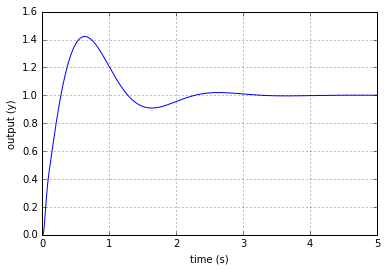

In [3]:
# plant transfer function
p = 1.0
P_tf = control.tf([0.05, 1.0], [1.0, -p]) * (control.tf([1], [0.01, 1.0]) ** 2)

# linear controller transfer function
k_p = 4.0
f_lp = 10.0
beta_lp = 0.7
f_i = 0.5
C_tf = k_p * control.tf([1.0, 2.0*np.pi*f_i], [1.0, 0.0]) * control.tf([1.0], [1.0/(2*np.pi*f_lp)**2, (2.0*beta_lp)/(2*np.pi*f_lp), 1.0])

# plot closed loop response
P_yr = control.feedback(P_tf * C_tf, 1)
ts = np.linspace(0, 5, 10000)
_, ys = control.step_response(P_yr, T=ts)
plt.plot(ts, ys)
plt.xlabel('time (s)')
plt.ylabel('output (y)')
plt.grid(True)

0.134252140671


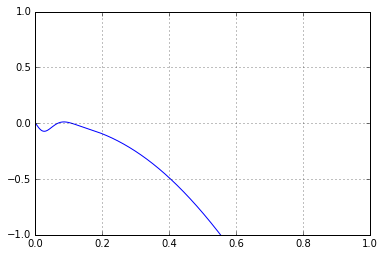

In [4]:
# compute rise time and overshoot minimum
sfun = interp1d(ts, ys, kind='cubic')
tr = 0.23 # computed by me
#tr = 0.28 # Hunnekens, et al. (2016)
plt.plot(ts, sfun(ts)-ts/tr)
plt.grid(True)
axes = plt.gca()
axes.set_ylim([-1.0, 1.0])
axes.set_xlim([0., 1.])

yos_min = ((p*tr - 1.)*np.exp(p*tr) + 1.)/(p*tr)
print yos_min

(0, 1.6)

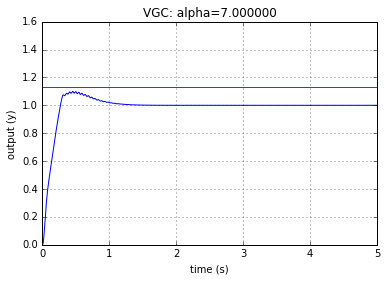

In [12]:
# convert loop transfer function to discrete time
dt = 0.001
alpha = 7
#A, B, C, D = control.ssdata(control.sample_system(P_tf * C_tf, Ts=dt, method='zoh'))
A = np.genfromtxt('vgc_A.csv', delimiter=',').reshape((6,6))
B = np.genfromtxt('vgc_B.csv', delimiter=',').reshape((6,1))
C = np.genfromtxt('vgc_C.csv', delimiter=',').reshape((1,6))
D = np.genfromtxt('vgc_D.csv', delimiter=',').reshape((1,1))

n_L, m_L = B.shape
n = n_L + 1
assert m_L == 1
assert D == 0

# state update equation
def f(x, e, alpha, dt):
    # state is x = (x_vgc, x_L) in R x R^n_L
    n = len(x)
    assert n == 1 + n_L
    assert len(e) == 1
    
    # unpack state components
    x_vgc = np.dot(np.eye(1,n,0), x)
    x_L = np.dot(np.eye(n-1,n,1), x)
    
    # estimate derivative and apply nonlinearity
    edot = 1.0/dt * (e - x_vgc)
    #e_vgc = true_vgc(e, edot, alpha) + e
    e_vgc = true_vgc(e, e - x_vgc, alpha) + e  # since the value of edot is not actually used
    
    # calculate next state
    x_vgc_next = e
    x_L_next = np.dot(A, x_L) + np.dot(B, e_vgc)
    
    # pack state components
    return np.concatenate((x_vgc_next.reshape((1,1)), x_L_next), axis=0)

# error readout equation
def h(x):
    n = len(x)
    assert n == 1 + n_L
    
    x_L = np.dot(np.eye(n-1,n,1), x)
    return np.dot(C, x_L)

# closed loop state update equation
def fcl(x, alpha, dt):
    x = x.reshape((n,1))
    return f(x, 1 - h(x), alpha, dt)

# simulate system
t_hist = np.arange(0, 5, dt)
x_hist = np.zeros((n, len(t_hist)))
x_hist[:,0] = np.zeros((n,))

for i, t in enumerate(t_hist[:-1]):
    x_hist[:,i+1] = fcl(x_hist[:,i], alpha=alpha, dt=dt).reshape((n,))
    
# plot output
plt.plot(t_hist, 1 - x_hist[0,:])
plt.plot([0, t_hist[-1]], [1 + yos_min, 1 + yos_min])
plt.xlabel('time (s)')
plt.ylabel('output (y)')
plt.title('VGC: alpha=%f' % alpha)
plt.grid(True)
axes = plt.gca()
axes.set_ylim([0, 1.6])

[ -7.68543007e-11   4.29529264e+00   5.36977182e-01   9.93185280e-12
   1.62351765e-11  -5.22931817e-12   6.75233011e-13]
[  9.99211682e-01  -1.54931921e-02  -8.77129114e-02   2.64931693e-02
  -5.30512129e-03   6.85151625e-03  -1.16965307e-04]

5000
==System A, B, C, D==
[[  1.00100050e+00  -8.00302351e-03   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   9.60357903e-01   4.63292094e-02
    4.31283654e-02  -1.25272062e-02]
 [  0.00000000e+00   0.00000000e+00  -4.63292094e-02   9.98887064e-01
   -1.61488265e-03   5.46378478e-04]
 [  0.00000000e+00   0.00000000e+00  -4.31283654e-02  -1.61488265e-03
    9.21486440e-01   5.93277213e-02]
 [  0.00000000e+00   0.00000000e+00  -1.25272062e-02  -5.46378478e-04
   -5.93277213e-02   8.40958785e-01]]
[[ -1.39462978e-03]
 [ -6.74785426e-03]
 [  2.27827311e-03]
 [ -1.61821601e-05]
 [  1

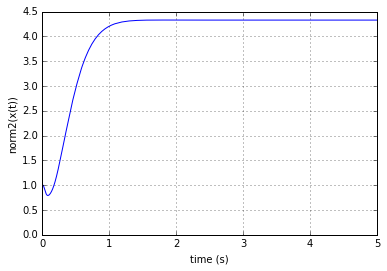

In [22]:
### check that the full state goes to zero
plt.plot(t_hist, np.linalg.norm(x_hist, axis=0, ord=2))
plt.xlabel('time (s)')
plt.ylabel('norm2(x(t))')
plt.grid(True)

print x_hist[:,-1]
print x_hist[:,6]
print
print len(t_hist)
print '==System A, B, C, D=='
print A
print B
print C
print D
print '==Singular values=='
U, S, V = np.linalg.svd(A)
print S
print '==Eigenvalues=='
print np.linalg.eigvals(A)
print control.ssdata(control.sample_system(P_tf * C_tf, Ts=dt, method='zoh'))
print n_L